# Fig4f - Fluorescence Intensity Analysis

## Overview
This notebook/script processes multi-frame TIFF image stacks from microscopy experiments to quantify fluorescence intensity profiles across the cell axis.  
It performs the following steps:
1. Loads a multi-frame `.tif` image stack.
2. Splits each frame into left and right halves relative to the cell center.
3. Calculates average horizontal intensity profiles for each half.
4. Bins the distance from the cell center into equal intervals.
5. Normalizes intensities (optional) and aggregates results across frames.
6. Saves the results to CSV and generates a mean profile plot in SVG format.

---

## Input Requirements
- Multi-frame TIFF file containing raw microscopy images.
- TIFF file should be pre-processed/aligned so that the cell's longitudinal axis is horizontal.
- Python environment with the following packages installed:
  - `numpy`
  - `pandas`
  - `matplotlib`
  - `Pillow`
  - `opencv-python`
- Sufficient disk space for saving CSV and SVG files.

---

## Outputs
- **CSV file**: Contains binned and normalized intensity profiles for each frame's left and right halves, plus the overall mean.
- **SVG plot**: Displays all profiles (semi-transparent) and the mean profile (bold black line).

---

## How to run

1. **Set paths:**
```python
INPUT_TIFF_FILE = "/path/to/your/input_stack.tif"      # Path to the multi-frame TIFF file
OUTPUT_SVG_FILE = "/path/to/save/analysis_plot.svg"    # Path to save the SVG plot
OUTPUT_CSV_FILE = "/path/to/save/analysis_data.csv"    # Path to save the CSV data
```

2. **Configure analysis parameters:**
```python
NUM_BINS = 20                # Number of bins for half-cell distance
NORMALIZE_INTENSITY = True   # Whether to normalize intensities to peak = 1
```
3. **Run all cells in order::**
   - Ensure dependencies are installed.
   - Execute each cell from top to bottom without skipping.

### 4. Check output files in the specified directory.
   - Open the `.svg` to verify the plot.
   - Open the `.csv` to inspect numerical values.

---


--- Configuration ---
Input TIFF: 02_Fig4f_straightener_output/-MinCDE/c2_FtsZ_straight_stack.tif
Output SVG: 04_Fig4f_plot_output/fig4f01.svg
Output CSV: 04_Fig4f_plot_output/fig4f01.csv
Number of Bins: 20
Normalize Intensity: True
---------------------

File loaded successfully: c2_FtsZ_straight_stack.tif (contains 17 frames).
Initiating frame-by-frame split-profile analysis...

--------------------------------------------------
All profiles processed. Aggregating data...
Generating plot...

Analysis complete!
SVG plot saved to: 04_Fig4f_plot_output/fig4f01.svg
CSV data file saved to: 04_Fig4f_plot_output/fig4f01.csv
--------------------------------------------------


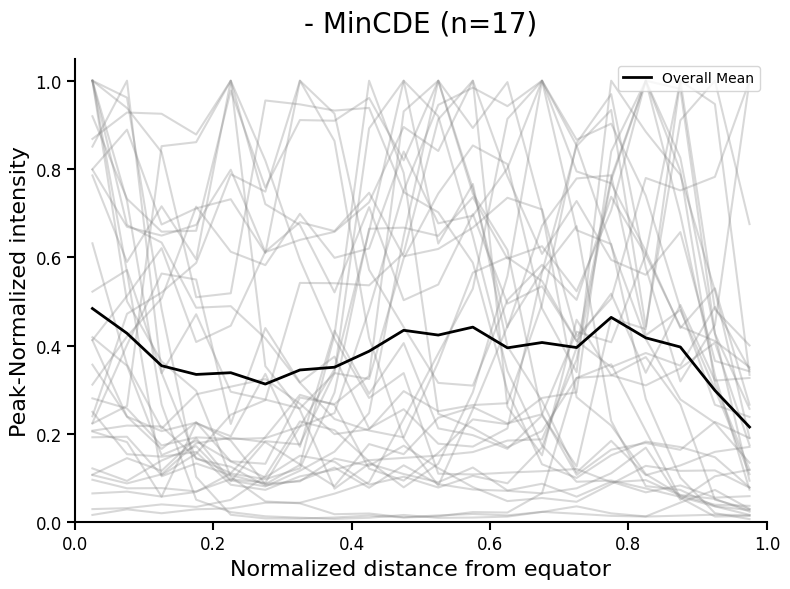

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
from pathlib import Path

# ==============================================================================
#                               CONFIGURATION
# ==============================================================================
# --- Define your input file, output files, and analysis parameters here ---

# 1. INPUT FILE
# Full path to the multi-frame TIFF file you want to analyze.
INPUT_TIFF_FILE = Path('02_Fig4f_straightener_output/-MinCDE/c2_FtsZ_straight_stack.tif')

# 2. OUTPUT FILES
# Full paths where you want to save the results.
OUTPUT_SVG_FILE = Path('04_Fig4f_plot_output/fig4f01.svg')
OUTPUT_CSV_FILE = Path('04_Fig4f_plot_output/fig4f01.csv')

# 3. ANALYSIS PARAMETERS
NUM_BINS = 20
NORMALIZE_INTENSITY = True
# ==============================================================================
#                      --- END OF CONFIGURATION ---
#             (No need to edit anything below this line)
# ==============================================================================


# --- 1. Input Validation and Setup ---
if not os.path.isfile(INPUT_TIFF_FILE):
    print(f"Error: The input file was not found at '{INPUT_TIFF_FILE}'")
    # Exit the script if the input file doesn't exist.
    exit()

# Ensure the output directories exist.
for path in [OUTPUT_CSV_FILE, OUTPUT_SVG_FILE]:
    output_dir = os.path.dirname(path)
    if not os.path.exists(output_dir):
        print(f"Output directory not found. Creating: '{output_dir}'")
        os.makedirs(output_dir)

print("--- Configuration ---")
print(f"Input TIFF: {INPUT_TIFF_FILE}")
print(f"Output SVG: {OUTPUT_SVG_FILE}")
print(f"Output CSV: {OUTPUT_CSV_FILE}")
print(f"Number of Bins: {NUM_BINS}")
print(f"Normalize Intensity: {NORMALIZE_INTENSITY}")
print("---------------------\n")


# --- 2. Data Loading ---
try:
    img_stack = Image.open(INPUT_TIFF_FILE)
    num_frames = img_stack.n_frames
    print(f"File loaded successfully: {os.path.basename(INPUT_TIFF_FILE)} (contains {num_frames} frames).")
    print("Initiating frame-by-frame split-profile analysis...")
except Exception as e:
    print(f"Error: Could not open or read the TIFF file.\nDetails: {e}")
    exit()

all_half_profiles = []
processed_half_names = []

# --- 3. Main Processing Loop for Each Frame ---
for frame_index, frame in enumerate(ImageSequence.Iterator(img_stack)):
    frame_name = f"frame_{frame_index}"
    try:
        # Convert frame to a grayscale NumPy array
        img = np.array(frame.convert('L'))

        if img is None or img.ndim != 2 or img.shape[0] == 0 or img.shape[1] == 0:
            print(f"Warning: Skipping {frame_name} due to invalid image data.")
            continue

        # Calculate the mean intensity profile along the horizontal axis
        profile = np.mean(img, axis=0)

        # Define a normalized coordinate system (center=0, edges=+/-1.0)
        x_centered = np.linspace(-1.0, 1.0, img.shape[1])
        x_distance = np.abs(x_centered)
        df_full = pd.DataFrame({
            'x_distance': x_distance,
            'intensity': profile,
            'original_x': x_centered
        })

        # Define bins for analysis
        bins = np.linspace(0, 1.0, NUM_BINS + 1)
        bin_labels = (bins[:-1] + bins[1:]) / 2
        expected_bin_pixels = img.shape[1] / 2 / NUM_BINS

        # Process Right Half
        df_right = df_full[df_full['original_x'] >= 0].copy()
        if not df_right.empty:
            df_right['bin'] = pd.cut(df_right['x_distance'], bins=bins, labels=bin_labels, include_lowest=True)
            profile_right = df_right.groupby('bin', observed=True).agg(intensity=('intensity', 'mean'), pixel_count=('bin', 'count'))
            profile_right['intensity'] *= profile_right['pixel_count'] / expected_bin_pixels
            if NORMALIZE_INTENSITY and profile_right['intensity'].max() > 0:
                profile_right['intensity'] /= profile_right['intensity'].max()
            all_half_profiles.append(profile_right['intensity'])
            processed_half_names.append(f"{frame_name}_right")

        # Process Left Half
        df_left = df_full[df_full['original_x'] < 0].copy()
        if not df_left.empty:
            df_left['bin'] = pd.cut(df_left['x_distance'], bins=bins, labels=bin_labels, include_lowest=True)
            profile_left = df_left.groupby('bin', observed=True).agg(intensity=('intensity', 'mean'), pixel_count=('bin', 'count'))
            profile_left['intensity'] *= profile_left['pixel_count'] / expected_bin_pixels
            if NORMALIZE_INTENSITY and profile_left['intensity'].max() > 0:
                profile_left['intensity'] /= profile_left['intensity'].max()
            all_half_profiles.append(profile_left['intensity'])
            processed_half_names.append(f"{frame_name}_left")

    except Exception as e:
        print(f"An error occurred while processing {frame_name}: {e}")

if not all_half_profiles:
    print("Error: No frames were processed successfully. Exiting.")
    exit()

# --- 4. Data Aggregation and CSV Output ---
print("\n" + "-"*50)
print("All profiles processed. Aggregating data...")

full_index = pd.Index(bin_labels, name='distance_from_center')
df_all_halves = pd.concat([p.reindex(full_index, fill_value=0) for p in all_half_profiles], axis=1)
df_all_halves.columns = processed_half_names

overall_mean = df_all_halves.mean(axis=1)
results_df = df_all_halves.copy()
results_df['overall_mean'] = overall_mean

# Save the aggregated data to the specified CSV path
results_df.to_csv(OUTPUT_CSV_FILE)

# --- 5. Visualization ---
print("Generating plot...")
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each individual profile with transparency
for col in df_all_halves.columns:
    ax.plot(df_all_halves.index, df_all_halves[col], color='gray', lw=1.5, alpha=0.3)

# Plot the overall mean profile prominently
ax.plot(overall_mean.index, overall_mean.values, color='black', lw=2, ls='-', label='Overall Mean')

# --- Chart Formatting ---
num_images = num_frames
num_profiles_plotted = len(all_half_profiles)
ax.set_title(f'- MinCDE (n={num_images})', fontsize=20, pad=20)
ax.set_xlabel('Normalized distance from equator', fontsize=16)
ylabel_text = 'Peak-Normalized intensity' if NORMALIZE_INTENSITY else 'Compensated Intensity'
ax.set_ylabel(ylabel_text, fontsize=16)

ax.set_xlim(0, 1.0)
ax.set_ylim(bottom=0)

for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', width=1.5, length=6, labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right')
plt.tight_layout()

# Save the plot to the specified SVG path
plt.savefig(OUTPUT_SVG_FILE, dpi=300, bbox_inches='tight', facecolor='white')

print("\nAnalysis complete!")
print(f"SVG plot saved to: {OUTPUT_SVG_FILE}")
print(f"CSV data file saved to: {OUTPUT_CSV_FILE}")
print("-" * 50)

# Display the plot after saving
plt.show()

--- Configuration ---
Input TIFF: 02_Fig4f_straightener_output/+MinCDE/c2_FtsZ_straight_stack.tif
Output SVG: 04_Fig4f_plot_output/fig5f02.svg
Output CSV: 04_Fig4f_plot_output/fig5f02.csv
Number of Bins: 20
Normalize Intensity: True
---------------------

File loaded successfully: c2_FtsZ_straight_stack.tif (contains 17 frames).
Initiating frame-by-frame split-profile analysis...

--------------------------------------------------
All profiles processed. Aggregating data...
Generating plot...

Analysis complete!
SVG plot saved to: 04_Fig4f_plot_output/fig5f02.svg
CSV data file saved to: 04_Fig4f_plot_output/fig5f02.csv
--------------------------------------------------


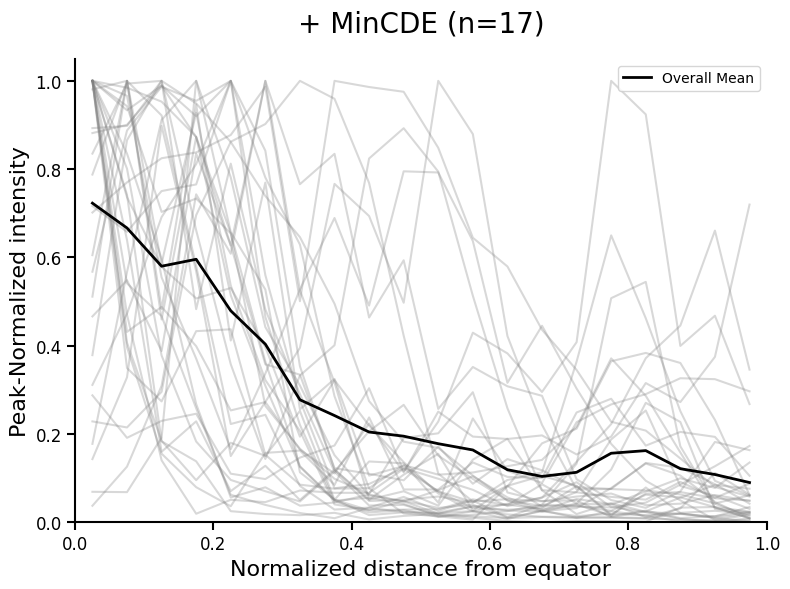

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence

# ==============================================================================
#                               CONFIGURATION
# ==============================================================================
# --- Define your input file, output files, and analysis parameters here ---

# 1. INPUT FILE
# Full path to the multi-frame TIFF file you want to analyze.
INPUT_TIFF_FILE = Path('02_Fig4f_straightener_output/+MinCDE/c2_FtsZ_straight_stack.tif')

# 2. OUTPUT FILES
# Full paths where you want to save the results.
OUTPUT_SVG_FILE = Path('04_Fig4f_plot_output/fig5f02.svg')
OUTPUT_CSV_FILE = Path('04_Fig4f_plot_output/fig5f02.csv')

# 3. ANALYSIS PARAMETERS
NUM_BINS = 20
NORMALIZE_INTENSITY = True
# ==============================================================================
#                      --- END OF CONFIGURATION ---
#             (No need to edit anything below this line)
# ==============================================================================


# --- 1. Input Validation and Setup ---
if not os.path.isfile(INPUT_TIFF_FILE):
    print(f"Error: The input file was not found at '{INPUT_TIFF_FILE}'")
    # Exit the script if the input file doesn't exist.
    exit()

# Ensure the output directories exist.
for path in [OUTPUT_CSV_FILE, OUTPUT_SVG_FILE]:
    output_dir = os.path.dirname(path)
    if not os.path.exists(output_dir):
        print(f"Output directory not found. Creating: '{output_dir}'")
        os.makedirs(output_dir)

print("--- Configuration ---")
print(f"Input TIFF: {INPUT_TIFF_FILE}")
print(f"Output SVG: {OUTPUT_SVG_FILE}")
print(f"Output CSV: {OUTPUT_CSV_FILE}")
print(f"Number of Bins: {NUM_BINS}")
print(f"Normalize Intensity: {NORMALIZE_INTENSITY}")
print("---------------------\n")


# --- 2. Data Loading ---
try:
    img_stack = Image.open(INPUT_TIFF_FILE)
    num_frames = img_stack.n_frames
    print(f"File loaded successfully: {os.path.basename(INPUT_TIFF_FILE)} (contains {num_frames} frames).")
    print("Initiating frame-by-frame split-profile analysis...")
except Exception as e:
    print(f"Error: Could not open or read the TIFF file.\nDetails: {e}")
    exit()

all_half_profiles = []
processed_half_names = []

# --- 3. Main Processing Loop for Each Frame ---
for frame_index, frame in enumerate(ImageSequence.Iterator(img_stack)):
    frame_name = f"frame_{frame_index}"
    try:
        # Convert frame to a grayscale NumPy array
        img = np.array(frame.convert('L'))

        if img is None or img.ndim != 2 or img.shape[0] == 0 or img.shape[1] == 0:
            print(f"Warning: Skipping {frame_name} due to invalid image data.")
            continue

        # Calculate the mean intensity profile along the horizontal axis
        profile = np.mean(img, axis=0)

        # Define a normalized coordinate system (center=0, edges=+/-1.0)
        x_centered = np.linspace(-1.0, 1.0, img.shape[1])
        x_distance = np.abs(x_centered)
        df_full = pd.DataFrame({
            'x_distance': x_distance,
            'intensity': profile,
            'original_x': x_centered
        })

        # Define bins for analysis
        bins = np.linspace(0, 1.0, NUM_BINS + 1)
        bin_labels = (bins[:-1] + bins[1:]) / 2
        expected_bin_pixels = img.shape[1] / 2 / NUM_BINS

        # Process Right Half
        df_right = df_full[df_full['original_x'] >= 0].copy()
        if not df_right.empty:
            df_right['bin'] = pd.cut(df_right['x_distance'], bins=bins, labels=bin_labels, include_lowest=True)
            profile_right = df_right.groupby('bin', observed=True).agg(intensity=('intensity', 'mean'), pixel_count=('bin', 'count'))
            profile_right['intensity'] *= profile_right['pixel_count'] / expected_bin_pixels
            if NORMALIZE_INTENSITY and profile_right['intensity'].max() > 0:
                profile_right['intensity'] /= profile_right['intensity'].max()
            all_half_profiles.append(profile_right['intensity'])
            processed_half_names.append(f"{frame_name}_right")

        # Process Left Half
        df_left = df_full[df_full['original_x'] < 0].copy()
        if not df_left.empty:
            df_left['bin'] = pd.cut(df_left['x_distance'], bins=bins, labels=bin_labels, include_lowest=True)
            profile_left = df_left.groupby('bin', observed=True).agg(intensity=('intensity', 'mean'), pixel_count=('bin', 'count'))
            profile_left['intensity'] *= profile_left['pixel_count'] / expected_bin_pixels
            if NORMALIZE_INTENSITY and profile_left['intensity'].max() > 0:
                profile_left['intensity'] /= profile_left['intensity'].max()
            all_half_profiles.append(profile_left['intensity'])
            processed_half_names.append(f"{frame_name}_left")

    except Exception as e:
        print(f"An error occurred while processing {frame_name}: {e}")

if not all_half_profiles:
    print("Error: No frames were processed successfully. Exiting.")
    exit()

# --- 4. Data Aggregation and CSV Output ---
print("\n" + "-"*50)
print("All profiles processed. Aggregating data...")

full_index = pd.Index(bin_labels, name='distance_from_center')
df_all_halves = pd.concat([p.reindex(full_index, fill_value=0) for p in all_half_profiles], axis=1)
df_all_halves.columns = processed_half_names

overall_mean = df_all_halves.mean(axis=1)
results_df = df_all_halves.copy()
results_df['overall_mean'] = overall_mean

# Save the aggregated data to the specified CSV path
results_df.to_csv(OUTPUT_CSV_FILE)

# --- 5. Visualization ---
print("Generating plot...")
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each individual profile with transparency
for col in df_all_halves.columns:
    ax.plot(df_all_halves.index, df_all_halves[col], color='gray', lw=1.5, alpha=0.3)

# Plot the overall mean profile prominently
ax.plot(overall_mean.index, overall_mean.values, color='black', lw=2, ls='-', label='Overall Mean')

# --- Chart Formatting ---
num_images = num_frames
num_profiles_plotted = len(all_half_profiles)
ax.set_title(f'+ MinCDE (n={num_images})', fontsize=20, pad=20)
ax.set_xlabel('Normalized distance from equator', fontsize=16)
ylabel_text = 'Peak-Normalized intensity' if NORMALIZE_INTENSITY else 'Compensated Intensity'
ax.set_ylabel(ylabel_text, fontsize=16)

ax.set_xlim(0, 1.0)
ax.set_ylim(bottom=0)

for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', width=1.5, length=6, labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right')
plt.tight_layout()

# Save the plot to the specified SVG path
plt.savefig(OUTPUT_SVG_FILE, dpi=300, bbox_inches='tight', facecolor='white')

print("\nAnalysis complete!")
print(f"SVG plot saved to: {OUTPUT_SVG_FILE}")
print(f"CSV data file saved to: {OUTPUT_CSV_FILE}")
print("-" * 50)

# Display the plot after saving
plt.show()